In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
# Nicer plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,4)

# APEX Gun, IMPACT-T

In [3]:
from impact import Impact, template_dir
from distgen import Generator

import matplotlib.pyplot as plt
import os

In [4]:
IMPACT_IN = os.path.join(template_dir,'apex_gun/ImpactT.in')
DISTGEN_IN = os.path.join(template_dir,'apex_gun/distgen.yaml')
os.path.exists(IMPACT_IN)

True

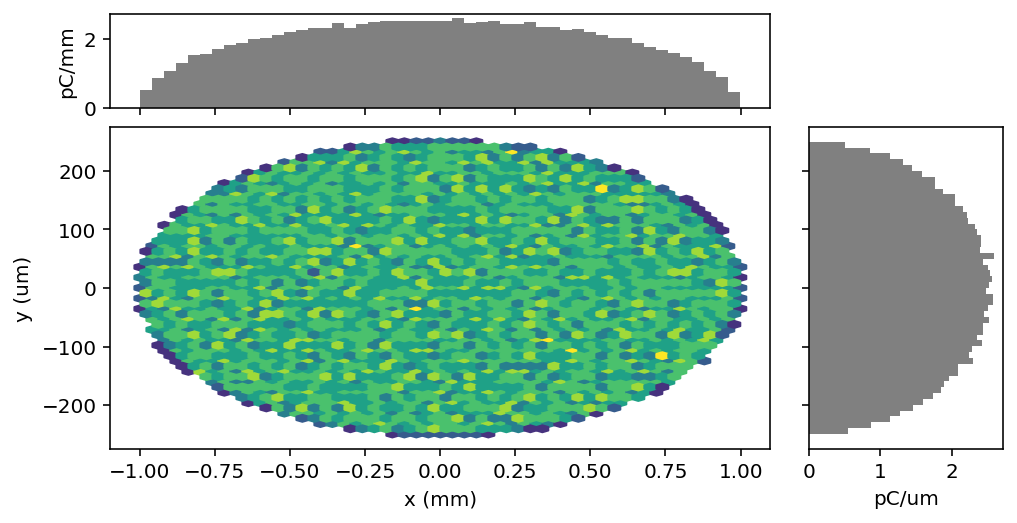

In [5]:
G = Generator(DISTGEN_IN)
G['n_particle'] = 10000

G.run()
P0 = G.particles
factor = 2
P0.x *= factor  
P0.y *= 1/factor 
P0.plot('x', 'y')

In [6]:
P0['charge']

1.0000000000000004e-10

In [7]:
# Make Impact object
I = Impact(IMPACT_IN, initial_particles = P0, verbose=True)

================ Impact-T Summary ================    
10000 particles
1 bunch of electrons
total charge: 0.0 pC
Distribution type: read
Cathode start at z = 0 m
   emission time: 1.2e-12 s
   image charges neglected after z = 0.02 m
Processor domain: 1 x 1 = 1 CPUs
Space charge grid: 16 x 16 x 16
Maximum time steps: 1000000
Reference Frequency: 1300000000.0 Hz
Initial reference time: 0.0 s
Simulation starting from the beginning

Configured to run in: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpnb2wymns


In [8]:
I.total_charge

0.0

In [9]:
# Change some things
I.header['Nx'] = 32
I.header['Ny'] = 32
I.header['Nz'] = 32
I.header['Dt'] = 1e-13

I.total_charge = P0['charge']
#I.total_charge = 0

# Other switches
I.timeout = 1000

# Switches for MPI
I.use_mpi=True
I.header['Nprow'] = 1
I.header['Npcol'] = 4
I.impact_bin = '$IMPACTT_MPI_BIN'
assert os.path.exists(os.path.expandvars(I.impact_bin))

In [10]:
# Change stop location
I.stop = 0.15


Removed element: stop_1
Set stop to s = 0.15


In [11]:
I.run()
print(I)

Running Impact-T in /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpnb2wymns
writing 10000 particles to /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpnb2wymns/partcl.data
Cathode start with cathode_kinetic_energy_ref = 1.0 eV
Cathode start: Replaced Np with 10000 according to initial particles
Cathode start: Replaced Bkenergy with 1.0 according to initial particles
Cathode start: Replaced Temission with 5.1434708345824233e-11 according to initial particles
Cathode start: Replaced Tini with -2.563423239338539e-11 according to initial particles
Setting total charge to 1.0000000000000004e-10 C
Loaded fort 30 : Fourth root of the fourth moments of the beam distribution
Loaded fort 25 : RMS Y information
Loaded fort 24 : RMS X information
Loaded fort 26 : RMS Z information
Loaded fort 28 : Load balance and loss diagnostics
Loaded fort 29 : Cube root of third moments of the beam distribution
Loaded fort 18 : Time and energy
Loaded fort 27 : Max amplitude information
Loaded fort 70 

# Particles

In [12]:
# Particles are automatically parsed in to openpmd-beamphysics ParticleGroup objects
I.output['particles']

{'initial_particles': <ParticleGroup with 10000 particles at 0x11c47c350>,
 'final_particles': <ParticleGroup with 10000 particles at 0x11c47c8d0>}

In [13]:
# Get the final particles, calculate some statistic
P = I.output['particles']['final_particles']
P['mean_energy']

1269377.1284507962

In [14]:
# Show the units
P.units('mean_energy')

pmd_unit('eV', 1.602176634e-19, (2, 1, -2, 0, 0, 0, 0))

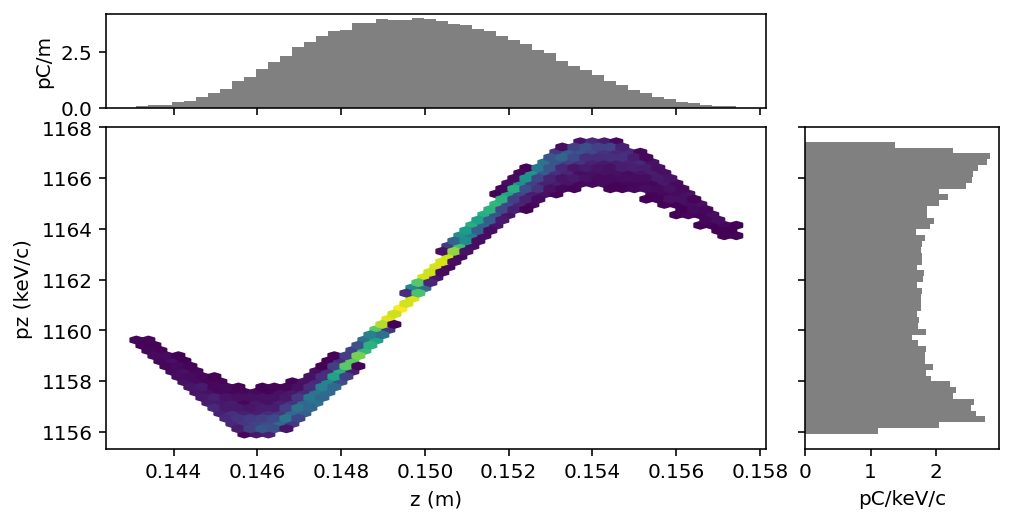

In [15]:
P.plot('z', 'pz')

# Stats

In [16]:
# Impact's own calculated statistics can be retieved
len(I.stat('norm_emit_x')), I.stat('norm_emit_x')[-1]

(1240, 1.6802911e-06)

In [17]:
# Stats can also be computed from the particles. For example:
I.particles['final_particles']['norm_emit_x']

1.6804920216499519e-06

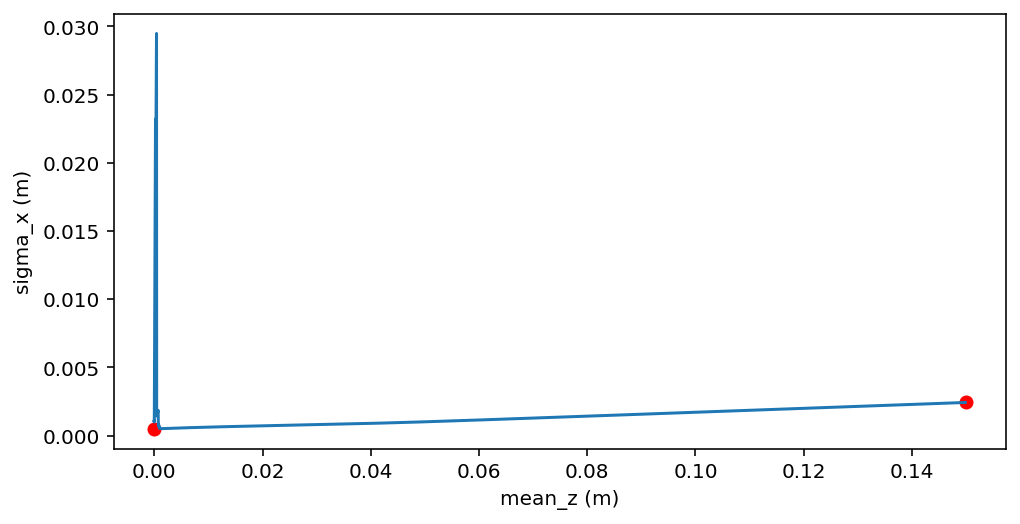

In [18]:
# Compare these. 
key1 = 'mean_z'
key2 = 'sigma_x'
units1 = str(I.units(key1))
units2 = str(I.units(key2))
plt.xlabel(key1+f' ({units1})')
plt.ylabel(key2+f' ({units2})')
plt.plot(I.stat(key1), I.stat(key2))
plt.scatter(
    [I.particles[name][key1] for name in I.particles], 
    [I.particles[name][key2] for name in I.particles], color='red')